In [1]:
"""
Construct score volume from score maps of each landmark
"""

%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import time

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed

In [2]:
volume_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'
patch_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_data_patches/'
scoremaps_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_scoremaps_lossless_svm_Sat16ClassFinetuned_v3/'
contourMap_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_outerContourMap'

In [3]:
labels = ['BackG'] + ['5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5'] + ['outerContour']

In [4]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor # 7.36 um
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [5]:
def load_scoremap(sec, name):
    '''
    Get the scoremap.
    Assume the scoremap is stored as a 2D array for scores within ROI at lossless scale +
    an interpBox file specifying bounding box coordinates at lossless scale

    Parameters
    ----------
    sec : int
        section number
    name : str
        label name
    
    Returns
    --------
    2d array
        downsampled full-frame scoremap
    '''
    
    global stack, downsample_factor
    
    scoremap_bp_filepath = scoremaps_rootdir + '/%(stack)s/%(slice)04d/%(stack)s_%(slice)04d_roi1_denseScoreMapLossless_%(label)s.hdf' \
            % {'stack': stack, 'slice': sec, 'label': name}
        
    if not os.path.exists(scoremap_bp_filepath):
        sys.stderr.write('No scoremap for section %d\n' % sec)
        return None
    
#     t = time.time()
    
    scoremap_roi = load_hdf(scoremap_bp_filepath)
    
#     sys.stderr.write('load hdf: %.2f seconds\n' % (time.time() - t))  

    interpolation_xmin, interpolation_xmax, \
    interpolation_ymin, interpolation_ymax = np.loadtxt(scoremaps_rootdir + \
                        '/%(stack)s/%(sec)04d/%(stack)s_%(sec)04d_roi1_denseScoreMapLossless_%(label)s_interpBox.txt' % \
                                    {'stack': stack, 'sec': sec, 'label': name}).astype(np.int)

#     t = time.time()
    
    scoremap = np.zeros((dm.image_height/downsample_factor, dm.image_width/downsample_factor), np.float32)
    
    interp_ymin = interpolation_ymin/downsample_factor
    interp_xmin = interpolation_xmin/downsample_factor
    
    scoremap_roi_downscaled = scoremap_roi[::downsample_factor, ::downsample_factor]
    interp_h, interp_w = scoremap_roi_downscaled.shape
    
#     print 'image width, height', dm.image_width/downsample_factor, dm.image_height/downsample_factor
#     print 'interp x', interpolation_xmin/downsample_factor, interpolation_xmax/downsample_factor
#     print 'interp y', interpolation_ymin/downsample_factor, interpolation_ymax/downsample_factor
#     print 'interp width, height', (interpolation_xmax-interpolation_xmin+1)/downsample_factor, (interpolation_ymax-interpolation_ymin+1)/downsample_factor
#     print 'roi x,y,w,h', roi_xmin_down, roi_ymin_down, roi_w_down, roi_h_down
#     print '\n'
    
    scoremap[interp_ymin:interp_ymin+interp_h, interp_xmin:interp_xmin+interp_w] = scoremap_roi_downscaled
        
    return scoremap

In [6]:
from skimage.transform import rescale, resize

def load_scoremap_tb(sec):
    ''' 
    Get scoremap. 
    Assume scoremap is stored as a 2D array for scores of the full frame at thumbnail scale.
    
    Parameters
    ----------
    sec : int
        section number
    
    Returns
    -------
    2d array
        downsampled full-frame scoremap
    '''
    global stack
        
    img_fn = contourMap_rootdir + '/%(stack)s/%(sec)04d/%(stack)s_%(sec)04d_denseScoremapThumbnail_outerContour.hdf' % \
                {'stack': stack, 'sec': sec}

    contour_prob_map = load_hdf(img_fn)
    
#     # crop at upper border of ROI box
#     xmin, ymin, w, h = detect_bbox_lookup[stack]
#     contour_prob_map[:ymin] = 0

    scoremap = resize(contour_prob_map, (h_down, w_down))
    return scoremap

In [8]:
for stack in ['MD603']:
# for stack in ['MD585', 'MD593', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
# for stack in ['MD591', 'MD595', 'MD598', 'MD602']:
    
    print stack
    
    section_roi_begin, section_roi_end = detect_bbox_range_lookup[stack]

    roi_xmin, roi_ymin, roi_w, roi_h = detect_bbox_lookup[stack]
    
    roi_h_down = roi_h*32/downsample_factor
    roi_w_down = roi_w*32/downsample_factor
    roi_ymin_down = roi_ymin*32/downsample_factor
    roi_xmin_down = roi_xmin*32/downsample_factor
    roi_zmin = int(section_roi_begin*z_xy_ratio_downsampled)
    roi_zmax = int((section_roi_end+1)*z_xy_ratio_downsampled)-1
    print roi_zmin, roi_zmax
    
    volume_dir = create_if_not_exists(os.path.join(volume_rootdir, stack))
    
    dm = DataManager(stack=stack)
    h_down = dm.image_height/downsample_factor
    w_down = dm.image_width/downsample_factor
    
    volume_xmin, volume_ymin, volume_zmin = (np.inf, np.inf, np.inf)
    volume_xmax, volume_ymax, volume_zmax = (0,0,0)

    t = time.time()
    
    for name in labels:
        
        if name == 'BackG':
            continue

        print name
                
        volume = np.zeros((h_down, w_down, int(section_number_lookup[stack]*z_xy_ratio_downsampled)), np.float32)
        
        t1 = time.time()
        
        if name == 'outerContour':
            scoremaps = Parallel(n_jobs=16)(delayed(load_scoremap_tb)(sec) for sec in range(section_roi_begin, section_roi_end+1))
        else:
            scoremaps = Parallel(n_jobs=16)(delayed(load_scoremap)(sec, name) for sec in range(section_roi_begin, section_roi_end+1))
        
        sys.stderr.write('load scoremap for %s: %.2f seconds\n' % (name, time.time() - t1)) # ~5s
        
        t1 = time.time()
        
        for i, sec in enumerate(range(section_roi_begin, section_roi_end+1)):
            m = scoremaps[i]
            if m is not None:
                volume[..., int(sec*z_xy_ratio_downsampled):int((sec+1)*z_xy_ratio_downsampled)] = m[..., None]
        
        volume_roi = volume[roi_ymin_down:roi_ymin_down+roi_h_down, 
                            roi_xmin_down:roi_xmin_down+roi_w_down,
                            roi_zmin:roi_zmax+1]

        sys.stderr.write('build volume for %s: %.2f seconds\n' % (name, time.time() - t1)) # ~30s

        bp.pack_ndarray_file(volume_roi,
                             volume_dir + '/%(stack)s_scoreVolume_%(label)s.bp' % {'stack': stack, 'label': name})

        del volume, volume_roi, scoremaps

    sys.stderr.write('build volume all: %.2f seconds\n' % (time.time() - t)) # 400 sec
    
    np.savetxt(volume_dir + '/%(stack)s_scoreVolume_limits.txt' % {'stack': stack},
               np.array((roi_xmin_down, roi_xmin_down+roi_w_down-1, 
                         roi_ymin_down, roi_ymin_down+roi_h_down-1, 
                         roi_zmin, roi_zmax))[None, :], 
               fmt='%d')

MD603
353 789
5N


load scoremap for 5N: 5.67 seconds
build volume for 5N: 22.13 seconds


7n


load scoremap for 7n: 4.82 seconds
build volume for 7n: 19.81 seconds
No scoremap for section 188


7N


load scoremap for 7N: 5.90 seconds
build volume for 7N: 23.10 seconds


12N


load scoremap for 12N: 5.14 seconds
build volume for 12N: 28.74 seconds


Pn


load scoremap for Pn: 8.18 seconds
build volume for Pn: 20.53 seconds


VLL


load scoremap for VLL: 7.37 seconds
build volume for VLL: 21.82 seconds


6N


load scoremap for 6N: 5.62 seconds
build volume for 6N: 20.40 seconds


Amb


load scoremap for Amb: 5.31 seconds
build volume for Amb: 19.56 seconds


R


load scoremap for R: 6.01 seconds
build volume for R: 21.74 seconds


Tz


load scoremap for Tz: 5.63 seconds
build volume for Tz: 20.70 seconds


RtTg


load scoremap for RtTg: 8.55 seconds
build volume for RtTg: 20.32 seconds


LRt


load scoremap for LRt: 6.70 seconds
build volume for LRt: 18.49 seconds


LC


load scoremap for LC: 6.05 seconds
build volume for LC: 18.93 seconds


AP


load scoremap for AP: 5.52 seconds
build volume for AP: 20.85 seconds


sp5


load scoremap for sp5: 7.65 seconds
build volume for sp5: 20.81 seconds


outerContour


load scoremap for outerContour: 5.42 seconds
build volume for outerContour: 19.87 seconds
build volume all: 509.96 seconds


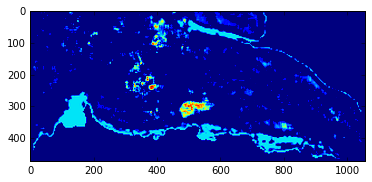

In [9]:
volume_roi = bp.unpack_ndarray_file(volume_dir + '/%(stack)s_scoreVolume_%(label)s.bp' % {'stack': stack, 'label': '5N'})
plt.imshow(volume_roi[..., 100]);